In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install all the libraries
!pip install openpyxl
!pip install -U transformers
!pip install -U datasets
!pip install tensorboard
!pip install sentencepiece
!pip install accelerate
!pip install evaluate
!pip install rouge_score
!pip install bert-extractive-summarizer
!pip install torch

In [ ]:
# Import all necessary modules
import pandas as pd
import re
from transformers import AutoModelForSeq2SeqLM, BartForConditionalGeneration, AutoTokenizer, TrainingArguments, Trainer
from datasets import Dataset, load_from_disk
from summarizer import Summarizer   # for bert-extractive-summarizer
from rouge_score import rouge
import evaluate

In [ ]:
# Load the pandas dataframe
df = pd.read_excel("/content/drive/MyDrive/CDAC Project: Text Summarization/raw_data/train.xlsx", engine="openpyxl")

# Setting up the display properties for pandas
pd.set_option('display.max_colwidth', None)  # Show full column values
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', 5000)         # Increase overall width

# Convert all data into string format
df = df.astype(str)

# Display the first 5 rows
print(df.head())

# Checking the data type
print(df.info())

# Checking the shape of the data
print(df.shape)

# Drop the id column
df.drop('id', axis=1,inplace=True)
print(df.shape)

#Rename the highlight column to summary
df.rename(columns={'highlights': 'summary'}, inplace=True)
print(df.columns)

                                         id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
# To get all the special characters

# Dictionary to store consecutive special character frequency
consecutive_char_freq = {}

# Loop through all columns and rows
for col in df.columns:
    for value in df[col]:
        # Find all sequences of consecutive special characters using regular expression
        consecutive_special_chars = re.findall(r'[^a-zA-Z0-9]+', str(value))  # Matches consecutive non-alphanumeric characters

        # Count the occurrences of each consecutive sequence
        for sequence in consecutive_special_chars:
            if sequence in consecutive_char_freq:
                consecutive_char_freq[sequence] += 1
            else:
                consecutive_char_freq[sequence] = 1

# Display the dictionary of consecutive special characters and their frequencies
sorted_dict = dict(sorted(consecutive_char_freq.items(), key=lambda item: item[1]))
print(sorted_dict)

{"!'). '": 1, '...)! ': 1, '?!"), ': 1, '). Â\xa0Â\xa0': 1, '!"\' - ': 1, ' *#*#': 1, '#*#* ': 1, ".'Â\xa0Â\xa0. ": 1, ".' <!--": 1, ';}': 1, ';}-->': 1, "' Ã¢â€°Â\xa0 '": 1, "'?.' ": 1, ".....'": 1, "!â€™â€\x9d' ": 1, "? - '": 1, '" - (': 1, 'Ã‚Â². ': 1, '\'!"), ': 1, '? --------------------------------------- . ': 1, ' : #': 1, '.â€\x8f . @': 1, 'â€\x8f . @': 1, ' :( . @': 1, 'Ã©... ': 1, ' . â€¢ Â\xa0': 1, "'!'. ": 1, ')... "': 1, ') ... "': 1, ' . > .': 1, ') Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0': 1, ') Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0': 1, ' Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0 Â\xa0': 1, '..." â€“ ': 1, ' [â€\x8f@': 1, ', Ä°': 1, "â€™' - ": 1, '  Â» . ': 1, 'Ã¶-': 1, "Ã¥'": 1, "Å›Ä‡', ": 1, ".â€Ž . '": 1, "?â€™'": 1, '.â€™"\'': 1, 

In [ ]:
# Replace the most frequent occuring encoding errors with their respective encoding
df = df.replace('â€™', "'", regex=True)
df = df.replace('Â£', "£", regex=True)
df = df.replace('“', '"', regex=True)
df = df.replace('Â\xa0', '', regex=True)
df = df.replace(' . ', '.', regex=True)
df = df.replace(': . ', ':', regex=True)
df = df.replace(' . | . ', '|', regex=True)
df = df.replace('(CNN) -- ', '', regex=True)
df = df.replace('â€˜', '', regex=True)
df = df.replace('â€"', '-', regex=True)
df = df.replace('ÃƒÂ©', 'é', regex=True)
df = df.replace('Ã´', 'ô', regex=True)
df = df.replace('â€\x9d', '"', regex=True)
df = df.replace('Â¿', '¿', regex=True)
df = df.replace('ÃƒÂ¯', 'î', regex=True)
df = df.replace('\x8d', '‹', regex=True)
df = df.replace('â€Š', '', regex=True)
df = df.replace('\n', '', regex=True)
df = df.replace('\t', ' ', regex=True)
df = df.replace(r'\[â€\\x8f@', '[—@', regex=True)
df = df.replace('â€œ', '"', regex=True)
df = df.replace('Ã¢â‚¬"', '—', regex=True)
df = df.replace('@@', '@', regex=True)
df = df.replace('Â½', '½', regex=True)
df = df.replace('Â©', '©', regex=True)
df = df.replace('Ã¤', 'ä', regex=True)
df = df.replace('â€‰â€¦â€‰', '...', regex=True)
df = df.replace('Ã¢', 'â', regex=True)
df = df.replace('â€‰...â€‰', '...', regex=True)
df = df.replace(';.â–\xa0', ';', regex=True)
df = df.replace('.â€\x8f@', '."@', regex=True)
df = df.replace("/'", "'", regex=True)
df = df.replace("Ã\x81", "Á", regex=True)
df = df.replace(" Ã\x81", "Á", regex=True)
df = df.replace("Â\xad", " ", regex=True)
df = df.replace("Ã¼", "ü", regex=True)
df = df.replace(".â€” ", ".—", regex=True)
df = df.replace("\) â€¢ ", "\)", regex=True)

In [ ]:
# Save the clean data
df.to_excel("/content/drive/MyDrive/CDAC Project: Text Summarization/clean_data/train.xlsx",index=False)

---

Extractive Summarization using BERT Extractive Summarizer

In [ ]:
# load the bert-extractive-summarizer model
model_bert = Summarizer()

# Load testing cleaned data in pandas dataframe
df_test = pd.read_excel("/content/drive/MyDrive/CDAC Project: Text Summarization/clean_data/train.xlsx", engine="openpyxl")

# Select 10 rows randomly
df_random = df_test.sample(n=10,random_state=7)

# Generate summaries
def generate_extractive_summary(text):
    return model_bert(text, ratio=0.2)  # Extract 20% of the most important sentences

# Create a new column in df_random
df_random["summary"] = df_random["article"].apply(generate_extractive_summary)

# Display the results
print(df_random[["article", "summary"]])

---

Abstractive Summarization using T5 model

In [ ]:
# Load and convert the clean data into hugging face dataframe format
hf_dataset = Dataset.from_pandas(pd.read_excel("/content/drive/MyDrive/CDAC Project: Text Summarization/clean_data/train.xlsx", engine="openpyxl"))
type(hf_dataset)

datasets.arrow_dataset.Dataset

In [ ]:
# Load model and tokenizer for t5-small using AutoModelForSeq2SeqLM and AutoTokenizer
model_name1 = "t5-small"
model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_name1)
tokenizer_t5 = AutoTokenizer.from_pretrained(model_name1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
# tokenize_t5 function to tokenize the data
def tokenize_t5(data):
  inputs = tokenizer_t5(data['article'], max_length=700, truncation=True, padding='max_length')
  labels = tokenizer_t5(data['summary'], max_length=50, truncation=True, padding='max_length')
  inputs['labels'] = labels['input_ids']
  return inputs

# Now apply tokenize function to all data
tokenized_df_t5 = hf_dataset.map(tokenize_t5, batched=True)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

In [ ]:
# Save the tokenized data
tokenized_df_t5.save_to_disk("/content/drive/MyDrive/CDAC Project: Text Summarization/tokenized_data/tokens_t5_small")

Saving the dataset (0/5 shards):   0%|          | 0/287113 [00:00<?, ? examples/s]

In [ ]:
# Load the tokenized data
tokenized_df_t5 = load_from_disk("/content/drive/MyDrive/CDAC Project: Text Summarization/tokenized_data/tokens_t5_small")

# Select the data for training, evaluation and testing
tokenized_train_t5 = tokenized_df_t5.select(range(5000))
tokenized_eval_t5 = tokenized_df_t5.select(range(5000,5500))
testing_df = hf_dataset.select(range(5500,5550))    # Here the testing data is not tokenized because during summary generation, text get tokenized

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/CDAC Project: Text Summarization/models/t5_model",
    evaluation_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=3,
    report_to="none"
)

# Initialize trainer
trainer_t5 = Trainer(
    model=model_t5,
    args=training_args,
    train_dataset=tokenized_train_t5,
    eval_dataset=tokenized_eval_t5
)

# Train the model
trainer_t5.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,2.184800,1.858892
2,1.959400,1.842999


TrainOutput(global_step=1250, training_loss=2.0423302001953125, metrics={'train_runtime': 564.8717, 'train_samples_per_second': 17.703, 'train_steps_per_second': 2.213, 'total_flos': 1850376192000000.0, 'train_loss': 2.0423302001953125, 'epoch': 2.0})

In [ ]:
# Evaluate the trainer object
trainer_t5.evaluate()

{'eval_loss': 1.8429986238479614,
 'eval_runtime': 9.2894,
 'eval_samples_per_second': 53.825,
 'eval_steps_per_second': 6.782,
 'epoch': 2.0}

In [ ]:
# Save the fine-tuned model and tokenizer
model_t5.save_pretrained("/content/drive/MyDrive/CDAC Project: Text Summarization/models/fine-tuned-t5-small")
tokenizer_t5.save_pretrained("/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/t5-tokenizer")

('/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/t5-tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/t5-tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/t5-tokenizer/spiece.model',
 '/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/t5-tokenizer/added_tokens.json',
 '/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/t5-tokenizer/tokenizer.json')

In [ ]:
# Load the fine-tuned model and tokenizer
model_t5 = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/CDAC Project: Text Summarization/models/fine-tuned-t5-small")
tokenizer_t5 = AutoTokenizer.from_pretrained("/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/t5-tokenizer")

In [ ]:
# Check if a GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define summarize_text arguments
def summarize_text_t5(
    text,
    max_length=80,
    min_length=50,
    temperature=1.0,          # Controls randomness (1.0=neutral, <1.0=conservative, >1.0=creative)
    top_k=50,                 # Consider top-k most probable tokens
    top_p=0.95,               # Consider smallest set of tokens with cumulative probability >= top_p
    repetition_penalty=1.2,   # Penalize repeated tokens (>1.0 penalizes, <1.0 encourages)
    num_beams=4,              # Beam search width
    length_penalty=2.0,       # Encourage longer summaries (>1.0), shorter (<1.0)
    early_stopping=True,      # Stop generation when all beams reach EOS
    do_sample=False           # Enable sampling-based generation
):
    # Preprocess with T5's required prefix
    text = "summarize: " + text

    # Tokenize input
    inputs = tokenizer_t5(
        text,
        return_tensors="pt",
        truncation=True,
        padding="longest",
        max_length=700
    )

    # Move input tensors to the same device as the model
    # inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate summary with configurable parameters
    summary_ids = model_t5.generate(
        inputs.input_ids,
        max_length=max_length,
        min_length=min_length,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        repetition_penalty=repetition_penalty,
        num_beams=num_beams,
        length_penalty=length_penalty,
        early_stopping=early_stopping,
        do_sample=do_sample
    )

    # Decode and clean output
    summary = tokenizer_t5.decode(
        summary_ids[0],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )

    return summary

In [ ]:
# Test the model on a sample article
for df in testing_df:
  article = df["article"]
  summary = summarize_text_t5(article)
  print("Original Article:\n", article)
  print("\nGenerated Summary:\n", summary)
  print("\n")

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Original Article:
 It was enough to leave the middle classes choking on their focaccia (well, if they'd had any to hand)..power cut left hundreds of Ocado customers without their online shopping at the weekend. Around 1,700 were told their groceries, mainly from Waitrose, had been cancelled or delayed.some were even warned their Ocado van would not arrive until 3.30am. Many complained that their weekend lunches and dinner parties had been ruined by.lack of such essentials as pork belly or pistachios. Jennifer Skillen, of Gloucestershire, posted.picture of Ocado avocados that were brown inside and wrote: 'I am rarely disappointed with Ocado but these avocados clearly didn't read 'ripen at home' on the label!' The problems began on Friday when, according to Ocado drivers,.power cut at.distribution centre caused orders to be delayed. An Ocado spokesman later attributed the delays to.faulty microchip. Shoppers soon went on Twitter to vent their frustration. Belinda Moore,.communications di

---

Abstractive Summarization using BART model

In [ ]:
# Load the pre-trained BART model and AutoTokenizer
model_name2 = "facebook/bart-base"

# Load the pre-trained BART model for summarization
model_bart = BartForConditionalGeneration.from_pretrained(model_name2)

# AutoTokenizer automatically loads the correct tokenizer
tokenizer_bart = AutoTokenizer.from_pretrained(model_name2)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# tokenize_t5 function to tokenize the data
def tokenize_bart(data):
  inputs = tokenizer_bart(data['article'], max_length=700, truncation=True, padding='max_length')
  labels = tokenizer_bart(data['summary'], max_length=50, truncation=True, padding='max_length')
  inputs['labels'] = labels['input_ids']
  return inputs

# Now apply tokenize function to all data
tokenized_df_bart = hf_dataset.map(tokenize_bart, batched=True)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

In [ ]:
# Save the tokenized data
tokenized_df_bart.save_to_disk("/content/drive/MyDrive/CDAC Project: Text Summarization/tokenized_data/tokens_bart")

Saving the dataset (0/5 shards):   0%|          | 0/287113 [00:00<?, ? examples/s]

In [ ]:
# Load the tokenized data
tokenized_df_bart.load_from_disk("/content/drive/MyDrive/CDAC Project: Text Summarization/tokenized_data/tokens_bart")

# Select the data for training, evaluation and testing
tokenized_train_bart = tokenized_df_bart.select(range(5000))
tokenized_eval_bart = tokenized_df_bart.select(range(5000,5500))

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/CDAC Project: Text Summarization/models/bart_model/",
    evaluation_strategy="epoch",          # Evaluate after each epoch
    learning_rate=3e-4,                   # Learning rate
    per_device_train_batch_size=8,        # Batch size for training
    per_device_eval_batch_size=8,         # Batch size for evaluation
    num_train_epochs=2,                   # Number of epochs
    weight_decay=0.01,
    save_total_limit=3,
    report_to="none"
)

# Initialize trainer
trainer_bart = Trainer(
    model=model_bart,
    args=training_args,
    train_dataset=tokenized_train_bart,
    eval_dataset=tokenized_eval_bart
)

# Fine-tune the model
trainer_bart.train()    # key = "7f485a71df1eb374e7351f178d4c164c22f1c24e"

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.413200,2.342430
2,1.970400,2.190738


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=1250, training_loss=2.0877664306640624, metrics={'train_runtime': 1081.1376, 'train_samples_per_second': 9.25, 'train_steps_per_second': 1.156, 'total_flos': 4168120320000000.0, 'train_loss': 2.0877664306640624, 'epoch': 2.0})

In [ ]:
# Evaluate the trainer object
trainer_bart.evaluate()

{'eval_loss': 2.1907382011413574,
 'eval_runtime': 13.4728,
 'eval_samples_per_second': 37.112,
 'eval_steps_per_second': 4.676,
 'epoch': 2.0}

In [ ]:
# Save the fine-tuned model and tokenizer
model_bart.save_pretrained("/content/drive/MyDrive/CDAC Project: Text Summarization/models/fine-tuned-bart-base")
tokenizer_bart.save_pretrained("/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/bart-tokenizer")

('/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/bart-tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/bart-tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/bart-tokenizer/vocab.json',
 '/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/bart-tokenizer/merges.txt',
 '/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/bart-tokenizer/added_tokens.json',
 '/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/bart-tokenizer/tokenizer.json')

In [ ]:
# Load the fine-tuned model and tokenizer
model_bart = BartForConditionalGeneration.from_pretrained("/content/drive/MyDrive/CDAC Project: Text Summarization/models/fine-tuned-bart-base")
tokenizer_bart = AutoTokenizer.from_pretrained("/content/drive/MyDrive/CDAC Project: Text Summarization/tokenizers/bart-tokenizer")

In [ ]:
# Define summarize_text arguments
def summarize_text_bart(
    text,
    max_length=80,
    min_length=50,
    temperature=1.0,          # Controls randomness (1.0=neutral, <1.0=conservative, >1.0=creative)
    top_k=50,                 # Consider top-k most probable tokens
    top_p=0.95,               # Consider smallest set of tokens with cumulative probability >= top_p
    repetition_penalty=1.2,   # Penalize repeated tokens (>1.0 penalizes, <1.0 encourages)
    num_beams=4,              # Beam search width
    length_penalty=2.0,       # Encourage longer summaries (>1.0), shorter (<1.0)
    early_stopping=True,      # Stop generation when all beams reach EOS
    do_sample=False           # Enable sampling-based generation
):
    # Preprocess with T5's required prefix
    text = "summarize: " + text

    # Tokenize input
    inputs = tokenizer_bart(
        text,
        return_tensors="pt",
        truncation=True,
        padding="longest",
        max_length=700
    )

    # Move input tensors to the same device as the model
    # inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate summary with configurable parameters
    summary_ids = model_bart.generate(
        inputs.input_ids,
        max_length=max_length,
        min_length=min_length,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        repetition_penalty=repetition_penalty,
        num_beams=num_beams,
        length_penalty=length_penalty,
        early_stopping=early_stopping,
        do_sample=do_sample
    )

    # Decode and clean output
    summary = tokenizer_bart.decode(
        summary_ids[0],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )

    return summary

In [ ]:
# Test the model on a sample article
for df in testing_df:
  article = df["article"]
  summary = summarize_text_bart(article)
  print("Original Article:\n", article)
  print("\nGenerated Summary:\n", summary)
  print("\n")

Original Article:
 It was enough to leave the middle classes choking on their focaccia (well, if they'd had any to hand)..power cut left hundreds of Ocado customers without their online shopping at the weekend. Around 1,700 were told their groceries, mainly from Waitrose, had been cancelled or delayed.some were even warned their Ocado van would not arrive until 3.30am. Many complained that their weekend lunches and dinner parties had been ruined by.lack of such essentials as pork belly or pistachios. Jennifer Skillen, of Gloucestershire, posted.picture of Ocado avocados that were brown inside and wrote: 'I am rarely disappointed with Ocado but these avocados clearly didn't read 'ripen at home' on the label!' The problems began on Friday when, according to Ocado drivers,.power cut at.distribution centre caused orders to be delayed. An Ocado spokesman later attributed the delays to.faulty microchip. Shoppers soon went on Twitter to vent their frustration. Belinda Moore,.communications di

---

Calculate the rouge score for evaluation

In [ ]:
# Rouge score
import random

# Define the valid range (after row 6000)
start_index = 6000
end_index = len(hf_dataset) - 1

# Get a random row from the dataset after index 5560
random_index = random.randint(start_index, end_index)
random_row = hf_dataset[random_index]

print(random_row)

# Generate summary for getting rouge score for t5
sample_article = random_row["article"]
generated_summary_t5 = summarize_text_t5(sample_article)

print("Original Article:\n", sample_article)
print("\nGenerated Summary:\n", generated_summary_t5)

print("################################################################################################################")

# Generate summary for getting rouge score for bart
sample_article = random_row["article"]
generated_summary_bart = summarize_text_bart(sample_article)

print("Original Article:\n", sample_article)
print("\nGenerated Summary:\n", generated_summary_bart)

{'article': "By.Steve Nolan.PUBLISHED:.10:02 EST, 10 April 2013.|.UPDATED:.01:45 EST, 11 April 2013.Finnish police have apologised after Russian President Vladimir Putin was mistakenly put on the country's secret list of criminals. The premier would have been arrested at the border had he tried to enter the country after he was added to the register for his contact with the Russian motorcycle gang Night Wolves. Mr Putin is not suspected of committing.crime in Finland himself and.police spokesman said that his name had now been removed and an investigation launched into how it got there. Fun in the snow: Russian president Vladimir Putin looked at ease as he rolled around in the snow near Moscow with his pet dogs Yume and Buffy.Man's best friend: Putin appeared to enjoy his walk with Bulgarian shepherd Buffy and Yume the Akita Inu.He's snow angel: Wearing his patriotic snow clothes, the Russian President is pictured lying with his pair of pets.Tonight Finland quickly removed.Putin's name

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Original Article:
 By.Steve Nolan.PUBLISHED:.10:02 EST, 10 April 2013.|.UPDATED:.01:45 EST, 11 April 2013.Finnish police have apologised after Russian President Vladimir Putin was mistakenly put on the country's secret list of criminals. The premier would have been arrested at the border had he tried to enter the country after he was added to the register for his contact with the Russian motorcycle gang Night Wolves. Mr Putin is not suspected of committing.crime in Finland himself and.police spokesman said that his name had now been removed and an investigation launched into how it got there. Fun in the snow: Russian president Vladimir Putin looked at ease as he rolled around in the snow near Moscow with his pet dogs Yume and Buffy.Man's best friend: Putin appeared to enjoy his walk with Bulgarian shepherd Buffy and Yume the Akita Inu.He's snow angel: Wearing his patriotic snow clothes, the Russian President is pictured lying with his pair of pets.Tonight Finland quickly removed.Putin'

In [ ]:
# Load the ROUGE metric
rouge = evaluate.load("rouge")

# Example reference and generated summaries
reference = random_row["summary"]

# Compute ROUGE scores
results_t5 = rouge.compute(predictions=[generated_summary_t5], references=[reference])

results_bart = rouge.compute(predictions=[generated_summary_bart], references=[reference])

# Print the ROUGE scores
print(results_t5)
print(results_bart)

# - *Hermann et al. (2015)* in Teaching Machines to Read and Comprehend used a mix of ROUGE metrics to evaluate text summarization models.
#      - [Paper Link](https://arxiv.org/pdf/1506.03340.pdf)
#    - *Narayan et al. (2018)* in Ranking Sentences for Extractive Summarization with Reinforcement Learning used *ROUGE-F1 scores as an aggregate measure*.
#      - [Paper Link](https://aclanthology.org/N18-1158.pdf)

results_t5["rouge1"]=results_t5["rouge1"]*0.25
results_t5["rouge2"]=results_t5["rouge2"]*0.25
results_t5["rougeL"]=results_t5["rougeL"]*0.25
results_t5["rougeLsum"]=results_t5["rougeLsum"]*0.25

results_bart["rouge1"]=results_bart["rouge1"]*0.25
results_bart["rouge2"]=results_bart["rouge2"]*0.25
results_bart["rougeL"]=results_bart["rougeL"]*0.25
results_bart["rougeLsum"]=results_bart["rougeLsum"]*0.25

sum_rouge_t5=0
sum_rouge_bart=0
for key, value in results_t5.items():
    sum_rouge_t5+=value

for key, value in results_bart.items():
    sum_rouge_bart+=value

print("Overall rouge score of t5-small :",sum_rouge_t5)
print("Overall rouge score of bart-base :",sum_rouge_bart)

{'rouge1': 0.3636363636363636, 'rouge2': 0.1395348837209302, 'rougeL': 0.20454545454545453, 'rougeLsum': 0.20454545454545453}
{'rouge1': 0.391304347826087, 'rouge2': 0.15555555555555559, 'rougeL': 0.30434782608695654, 'rougeLsum': 0.30434782608695654}
Overall rouge score of t5-small : 0.22806553911205074
Overall rouge score of bart-base : 0.2888888888888889


In [ ]:
# Load the BLEU metric
bleu = evaluate.load("bleu")

# Example reference and generated summaries
reference = random_row["summary"]

# Compute ROUGE scores
results_t5 = bleu.compute(predictions=[generated_summary_t5], references=[reference])

results_bart = bleu.compute(predictions=[generated_summary_bart], references=[reference])

# Print the ROUGE scores
print(results_t5)
print(results_bart)

{'bleu': 0.0, 'precisions': [0.4, 0.07692307692307693, 0.02631578947368421, 0.0], 'brevity_penalty': 0.7595721232249686, 'length_ratio': 0.7843137254901961, 'translation_length': 40, 'reference_length': 51}
{'bleu': 0.07371679775777677, 'precisions': [0.4, 0.11363636363636363, 0.046511627906976744, 0.023809523809523808], 'brevity_penalty': 0.8751733190429475, 'length_ratio': 0.8823529411764706, 'translation_length': 45, 'reference_length': 51}


Conclusions

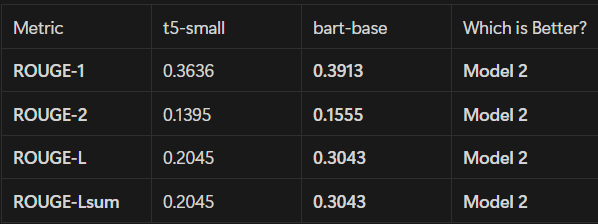

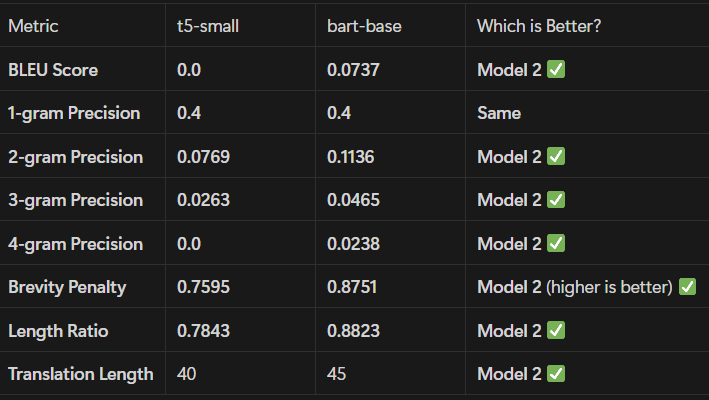

**You can see that in Model 2 performs better in both ROUGE and BLEU metrics**
<br>
So, we can conclude that Model 2 i.e. BART is better for text summarization


